# 1. Problem Description & Motivation

Most robots are composed of 3 main parts:
- The Controller ‐ also known as the "brain" which is run by a computer program.
- Mechanical parts ‐ motors, pistons, grippers, wheels, and gears that make the robot move, grab, turn, and lift.
- Sensors ‐ to tell the robot about its surroundings.

For a robot to learn and carry out a task correctly, it needs to rely and integrate all 3 components effectively.
In our problem, we help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).
*IMU sensor data* is collected while driving a small mobile robot over *different floor surfaces* on the university premises. The task is to **predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity**.

## What is IMU?
IMU stands for Inertial Measurement Unit, which is an electronic device that measures and reports a body's specific force, angular rate, and sometimes the magnetic field surroundings the body, using a combination of [accelerometers](https://en.wikipedia.org/wiki/Accelerometer) and [gyroscopes](https://en.wikipedia.org/wiki/Gyroscope),  sometimes also [magnetometers](https://en.wikipedia.org/wiki/Magnetometers). With these 3 incorporated sensors, the IMU measures at least 3 different types of quantities:
1. 3D Orientation
2. Linear Acceleration
3. Angular Acceleration

# 2. Data Acquisition

The dataset that we will be using comes a [Kaggle Competition](https://www.kaggle.com/c/career-con-2019/data).
x_train/test.csv = the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns
- row_id: The ID for this row.

- series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.

- measurement_number: Measurement number within the series.

y_train.csv = the surfaces for training set.

- series_id: ID number for the measurement series.

- group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

- surface: the target for this competition.

# 3. Data Exploration

In [2]:
#%matplotlib notebook
%matplotlib inline


#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import all data and labels
x_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
x_test = pd.read_csv('./data/X_test.csv')

print('X_train has {} rows, {} columns.'.format(x_train.shape[0],x_train.shape[1]))
print('y_train has {} rows, {} columns.'.format(y_train.shape[0],y_train.shape[1]))
print('X_test has {} rows, {} columns.'.format(x_test.shape[0],x_test.shape[1]))

X_train has 487680 rows, 13 columns.
y_train has 3810 rows, 3 columns.
X_test has 488448 rows, 13 columns.


It seems that number of rows for X_train is different from y_train. Let us explore the data further.

In [2]:
#print(x_train.head())
#print(y_train.head())
#print(x_train.describe())
#print(y_train.describe())


Check for missing or repeated data: 0 missing data, 0 duplicated data

In [3]:
print(x_train.isnull().sum())
x_test.isnull().sum()
y_train.isnull().sum()

print(x_train.duplicated().value_counts())
print(y_train.duplicated().value_counts())


row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64
False    487680
dtype: int64
False    3810
dtype: int64


Sort and ensure data is in sampled order (measurement_number and series_id)
Store time series data in 3D array(series_id, time order, features)

In [4]:
x_train_sorted = x_train.sort_values(by = ['series_id', 'measurement_number'])
y_train_sorted = y_train.sort_values(by = ['series_id', 'group_id'])
print(x_train_sorted.head())
print(y_train_sorted.head())
col = x_train.columns.values #stores the feature names

  row_id  series_id  measurement_number  orientation_X  orientation_Y  \
0    0_0          0                   0       -0.75853       -0.63435   
1    0_1          0                   1       -0.75853       -0.63434   
2    0_2          0                   2       -0.75853       -0.63435   
3    0_3          0                   3       -0.75852       -0.63436   
4    0_4          0                   4       -0.75852       -0.63435   

   orientation_Z  orientation_W  angular_velocity_X  angular_velocity_Y  \
0       -0.10488       -0.10597            0.107650            0.017561   
1       -0.10490       -0.10600            0.067851            0.029939   
2       -0.10492       -0.10597            0.007275            0.028934   
3       -0.10495       -0.10597           -0.013053            0.019448   
4       -0.10495       -0.10596            0.005135            0.007652   

   angular_velocity_Z  linear_acceleration_X  linear_acceleration_Y  \
0            0.000767               -0.

In [5]:
a = np.zeros(((x_train.shape[0]//128),128,10)) #create 3D array [series_id][time_order][feature]
for j in range(a.shape[2]):
    for i in range(a.shape[0]):
        a[i,:,j]=x_train_sorted.ix[i*128:128*(i+1)-1, col[3+j]]


C:\Users\Admin\Miniconda3\envs\CE9010_2019\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [6]:
#display Min-Max of each feature for a 
def min_max_values(col):
    top = X_train[col].idxmax()
    top_obs = pd.DataFrame(X_train.loc[top])
    
    bottom = X_train[col].idxmin()
    bot_obs = pd.DataFrame(X_train.loc[bottom])
    
    min_max_obs = pd.concat([top_obs, bot_obs], axis = 1)
    
    return min_max_obs

<Figure size 432x288 with 0 Axes>

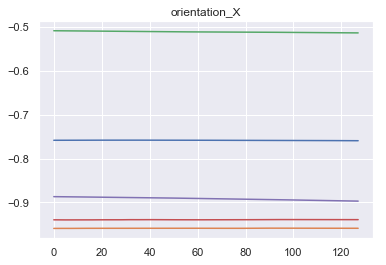

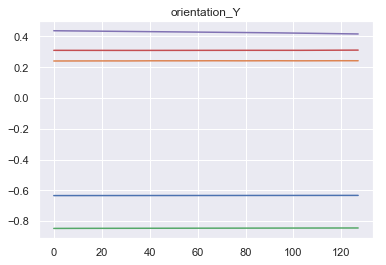

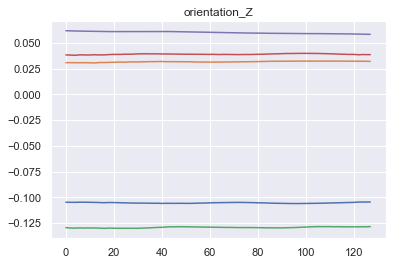

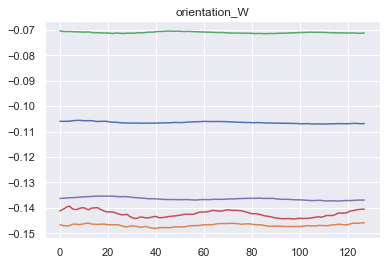

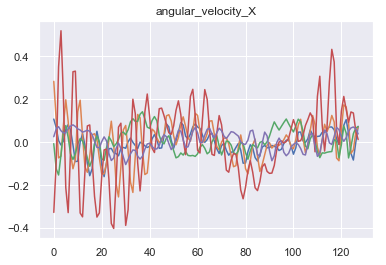

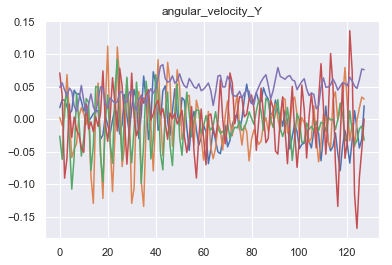

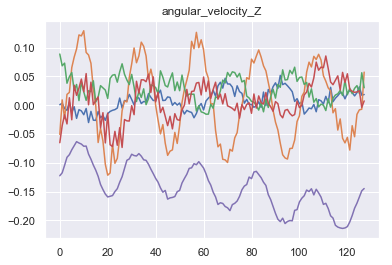

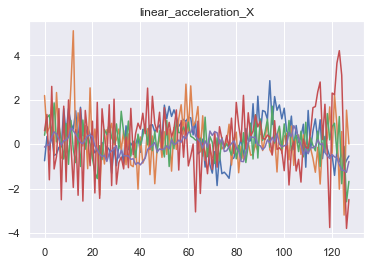

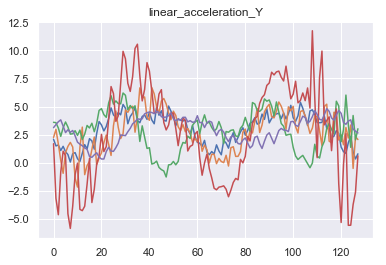

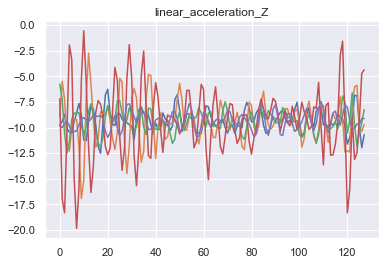

In [25]:
#plot data to see time series
#print(a[0,0:128,0])
time_order = [x for x in range(128)]

plt.figure()
for j in range(10):
    plt.figure()
    plt.title(col[j+3])
    for i in range(5):
        plt.plot(time_order,a[i,:,j])
       







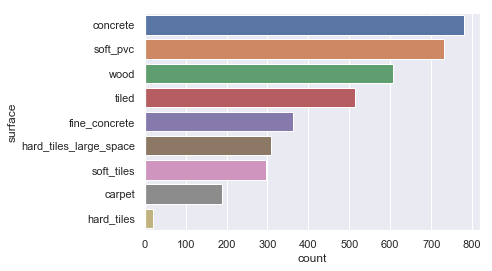

In [3]:
y_labels = list(y_train['surface'].value_counts().index)
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = y_train,
              order = y_labels)


[ 0.         0.0078125  0.015625   0.0234375  0.03125    0.0390625
  0.046875   0.0546875  0.0625     0.0703125  0.078125   0.0859375
  0.09375    0.1015625  0.109375   0.1171875  0.125      0.1328125
  0.140625   0.1484375  0.15625    0.1640625  0.171875   0.1796875
  0.1875     0.1953125  0.203125   0.2109375  0.21875    0.2265625
  0.234375   0.2421875  0.25       0.2578125  0.265625   0.2734375
  0.28125    0.2890625  0.296875   0.3046875  0.3125     0.3203125
  0.328125   0.3359375  0.34375    0.3515625  0.359375   0.3671875
  0.375      0.3828125  0.390625   0.3984375  0.40625    0.4140625
  0.421875   0.4296875  0.4375     0.4453125  0.453125   0.4609375
  0.46875    0.4765625  0.484375   0.4921875 -0.5       -0.4921875
 -0.484375  -0.4765625 -0.46875   -0.4609375 -0.453125  -0.4453125
 -0.4375    -0.4296875 -0.421875  -0.4140625 -0.40625   -0.3984375
 -0.390625  -0.3828125 -0.375     -0.3671875 -0.359375  -0.3515625
 -0.34375   -0.3359375 -0.328125  -0.3203125 -0.3125    -0.304

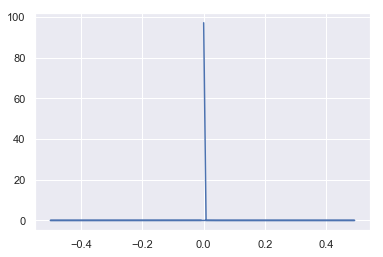

In [9]:
freq = np.fft.fftfreq(128)
amp = np.abs(np.fft.fft(a[0,:,0]))
print(freq,amp)
# plt.xlim((0,0.1))
plt.plot(freq, amp)


Text(0.5, 1.0, 'x_train Features Correlation Heat Map')

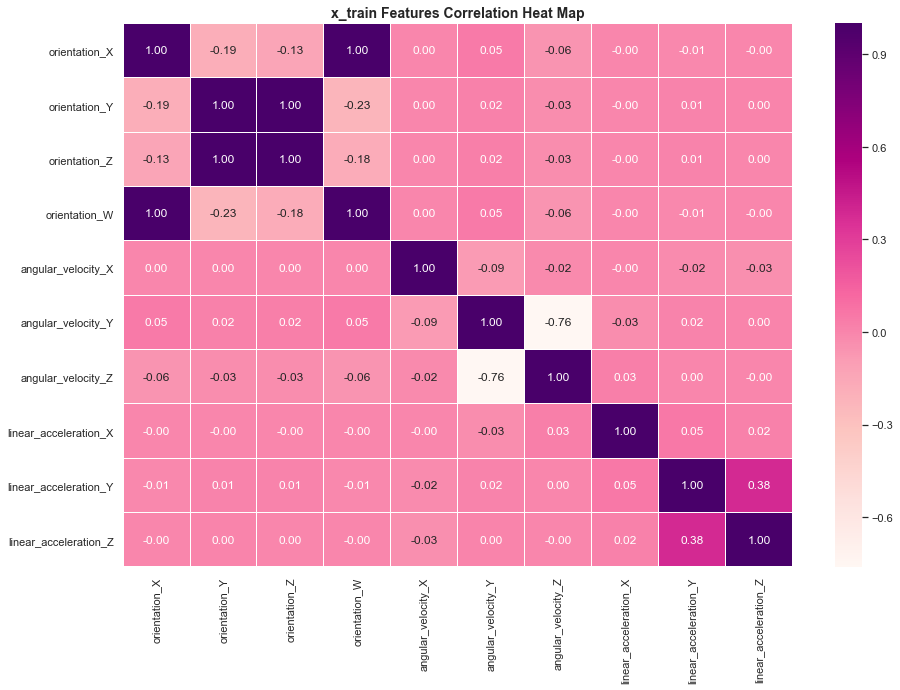

In [23]:
corr = x_train.corr()
corr

figure, axes = plt.subplots(1,1, figsize = (15,10))

heatmap = sns.heatmap(x_train.iloc[:,3:].corr(), ax = axes, cmap = 'RdPu', annot = True, fmt = '.2f', linewidths = 0.01)
heatmap.set_title('x_train Features Correlation Heat Map', fontsize=14, fontweight='bold')

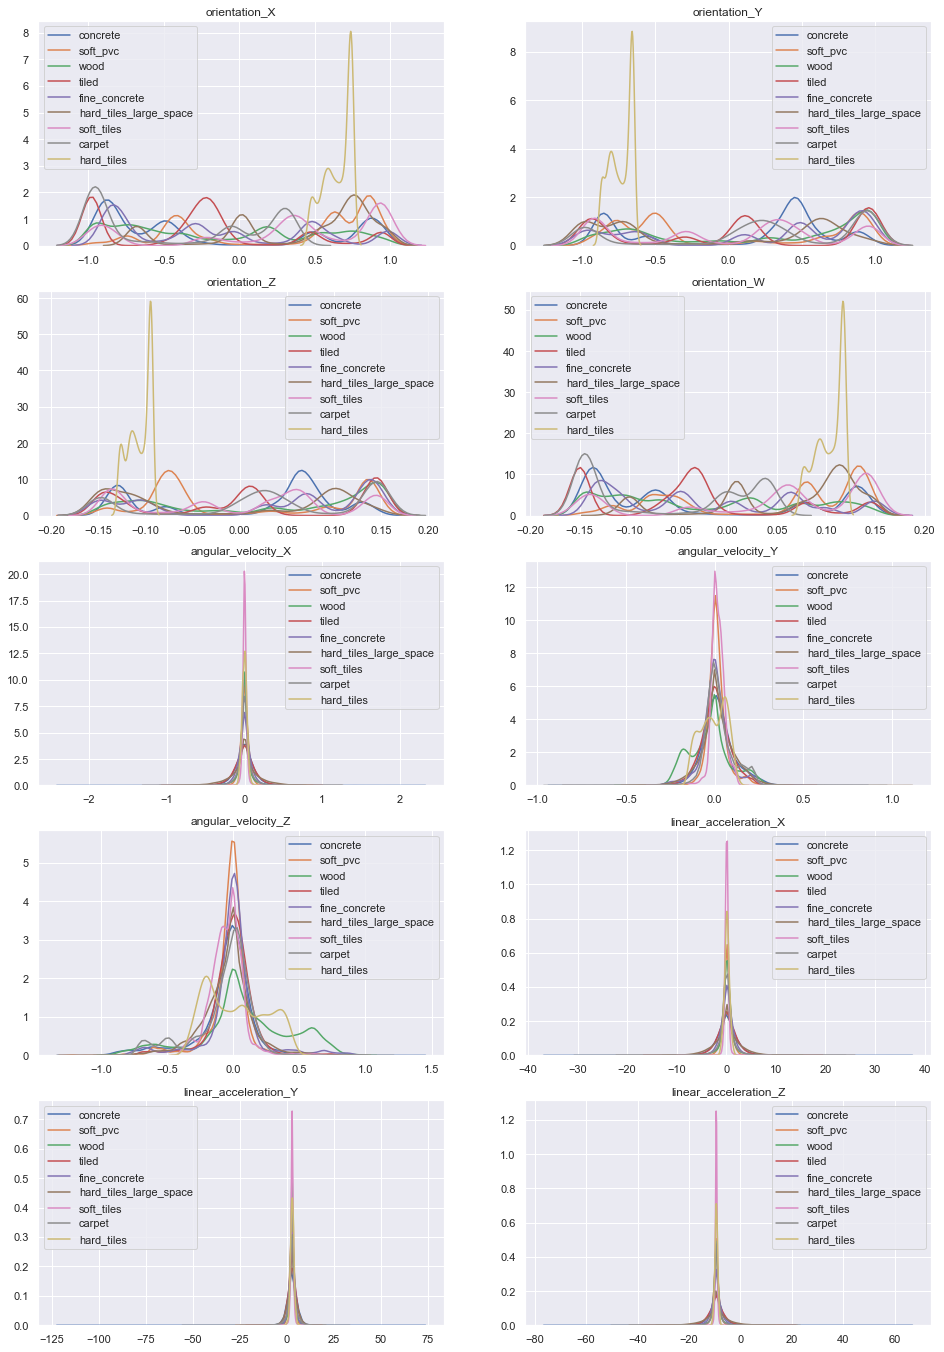

In [24]:
tmp = x_train.merge(y_train, on = 'series_id', how = 'inner')

plt.figure(figsize=(16, 24))
for index,column in enumerate(x_train.columns[3:13]):
    plt.subplot(5,2,index+1)
    plt.title(column)
    for surface in y_labels:
        surface_feature = tmp[tmp['surface'] == surface]
        sns.kdeplot(surface_feature[column], label = surface)


# 4. Data Preprocessing